https://habr.com/ru/post/318970/                                                                                            
https://ruder.io/optimizing-gradient-descent/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator

In [2]:
# using code from chapter 5
from sklearn.preprocessing import PolynomialFeatures
def polynomial_x(xx, p, sk_or_mine='sklearn'):
    if sk_or_mine == 'sklearn':
        p = PolynomialFeatures(degree=p)
        return p.fit_transform(xx)
    else: 
        x_powers = [xx**(p+1) for p in range(p)]
        x_concated = np.hstack((np.array(x_powers)))
    #     print(x_concated.shape, xx.shape, p)
        return x_concated.reshape(xx.shape[0], xx.shape[1]*p)
    
def cent_normalize(*args):
    for xx in args:
        yield xx - xx.mean(0)
        
def generate_data_of_degree(p=1, m=100, n=1, sk_or_mine='sklearn'):
    '''
    m - number of examples
    p - max power of polynomial
    n - features of x
    '''
    x = 3*np.random.normal(0,1,(m,n))
    x /= x.max()
    x_polyn = polynomial_x(x, p, 'sklearn')
    W = np.random.uniform(2, 3, (x_polyn.shape[1], 1))
    b = np.random.uniform(2, 3, (m, 1))
    
    y = b - x_polyn@W
    return y/y.max(), x

In [3]:
y_1, x_1 = cent_normalize(*generate_data_of_degree(p=1, m=30, n=1))

In [4]:
y_1.shape, x_1.shape

((30, 1), (30, 1))

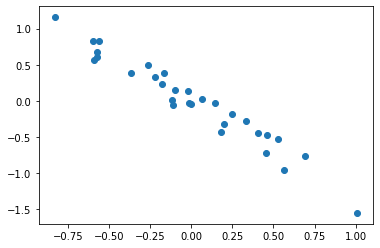

In [5]:
plt.scatter(x_1, y_1)

In [6]:
def OLS(X, y):
    '''
    pseudoinverse with SVD
    '''
    U,E,V_T = np.linalg.svd(X)
    sigmas_plus = np.zeros((X.shape[0], X.shape[1])).T
    sigmas_plus[:E.shape[0], :E.shape[0]] = np.linalg.inv(np.diag(E))
    return V_T.T@sigmas_plus@U.T@y

In [7]:
def regularized_OLS(X, y, lamda=0.1):
    return np.linalg.inv(X.T@X + lamda*np.eye(X.shape[1], X.shape[1]))@X.T@y

In [8]:
def plot_data_with_prediction(xx, yy, pred, title=''):
    plt.figure()
    plt.scatter(xx, yy, s=None, marker='.', color='g', alpha=0.9)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(xx, pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, color='m')
    plt.title(title)
    plt.show()

In [9]:
w_1 = OLS(x_1, y_1)

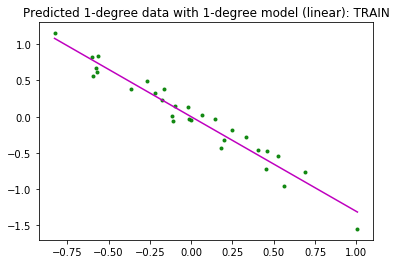

In [10]:
plot_data_with_prediction(x_1, y_1, x_1@w_1, 'Predicted 1-degree data with 1-degree model (linear): TRAIN')

In [117]:
# SGD

def simple_SGD_step(theta, eps, grad):
    g = -eps*grad
    theta_ = theta + g
    return theta_

def nesterov_step(v_t, gamma, theta, lr, grad):
    v_t_ = gamma*v_t + lr*grad
    theta_ = theta - v_t_
    return theta_, v_t_

def adagrad_step(G_t, gamma, theta, eps, grad):
    G_t_ = G_t + grad**2
    theta_ = theta - (1-gamma)/np.sqrt(eps + G_t_)*grad
    return theta_, G_t_

def rmsprop_step(G_t, gamma, theta, eps, grad):
    G_t_ = gamma*G_t + (1-gamma)*(grad**2)
    theta_ = theta - (1-gamma)/np.sqrt(G_t_+eps)*grad
    return theta_, G_t_

In [118]:
def train_lin_reg(train_x, train_y, optim='sgd', epochs=20):
    loss = []
    w = np.zeros((train_x.shape[1], 1))
    if optim == 'sgd':
        for i in range(epochs):
            grad = train_x.T@train_x@w-train_x.T@train_y 
            loss_ = np.linalg.norm(train_x@w-train_y, )
#             print(i, loss_, w.mean())
            loss.append(loss_)
            w = simple_SGD_step(w, 0.1, grad)
            
    if optim == 'nesterov':
        v_t = 0
        for i in range(epochs):
            grad = train_x.T@train_x@w-train_x.T@train_y
            loss_ = np.linalg.norm(train_x@w-train_y, )
#             print(i, loss_, w.mean())
            loss.append(loss_)
            w, v_t = nesterov_step(v_t, 0.5, w, 0.1, grad)
    if optim == 'adagrad':
        G_t = 0
        for i in range(epochs):
            grad = train_x.T@train_x@w-train_x.T@train_y
            loss_ = np.linalg.norm(train_x@w-train_y, )
#             print(i, loss_, w.mean())
            loss.append(loss_)
            w, G_t_ = adagrad_step(G_t, 0.5, w, 1e-7, grad)
            G_t += G_t_
    if optim == 'rmsprop':
        G_t = 0
        for i in range(epochs):
            grad = train_x.T@train_x@w-train_x.T@train_y
            loss_ = np.linalg.norm(train_x@w-train_y, )
#             print(i, loss_, w.mean())
            loss.append(loss_)
            w, G_t = rmsprop_step(G_t, 0.5, w, 1e-7, grad)
    return loss

In [119]:
J_sgd_reg = train_lin_reg(x_1, y_1)

In [120]:
J_nes_reg = train_lin_reg(x_1, y_1, optim='nesterov')

In [121]:
y_1_test, x_1_test = cent_normalize(*generate_data_of_degree(p=1, m=30, n=10))

In [122]:
J_sgd_reg = train_lin_reg(x_1_test, y_1_test)

In [123]:
J_nes_reg = train_lin_reg(x_1_test, y_1_test, optim='nesterov')

In [124]:
J_ada_reg = train_lin_reg(x_1_test, y_1_test, optim='adagrad')

In [125]:
J_ada_rms = train_lin_reg(x_1_test, y_1_test, optim='rmsprop')

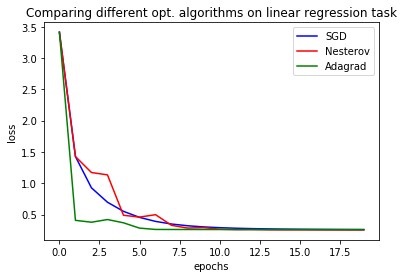

In [126]:
plt.title('Comparing different opt. algorithms on linear regression task')
plt.plot(range(len(J_sgd_reg)), J_sgd_reg, c='b', label='SGD')
plt.legend(loc='upper right')
plt.plot(range(len(J_nes_reg)), J_nes_reg, c='r',  label='Nesterov')
plt.legend(loc='upper right')
plt.plot(range(len(J_nes_reg)), J_ada_reg, c='g',  label='Adagrad')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [127]:
# test on binary logistic regression

In [128]:
x_0, y_0 = np.random.randn(100,2), np.zeros((100,1))
x_1, y_1 = np.random.randn(100,2) + 2, np.ones((100,1))

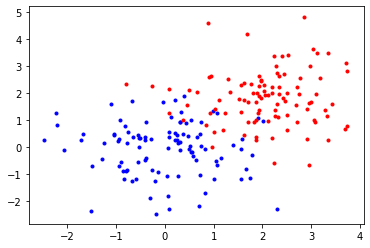

In [129]:
plt.scatter(x_0[:,0], x_0[:,1], c='b', marker='.')
plt.scatter(x_1[:,0], x_1[:,1], c='r', marker='.')
plt.show()

In [130]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [131]:
# p~(y|x) = 1/(1+e^wx)
# J(w) = -1/m*[y.T@log(p~(y|x)) + (1-y).T@log(1-p~(y|x))]
# grad_w J(w) = 1/m*x(p~(y|x)-y)

In [132]:
def sigm(z):
    return 1/(1+np.e**(-z))

In [133]:
def train_log_reg(train_x, train_y, optim='sgd', epochs=20):
    x = np.hstack([train_x,np.ones((train_x.shape[0], 1))])
    w = np.zeros((x.shape[1], 1))
    m = x.shape[0]
    loss = []
    if optim == 'sgd':
        for i in range(epochs):
            pred = sigm(x@w)
            J = -1/m*(train_y.T@np.log(pred)+(1-train_y).T@(1-np.log(pred)))
            print('Accuraccy:', ((pred>0.5) == train_y).sum()/pred.shape[0])
#             print('Loss:', J[0][0])
#             print('---'*20)
            loss.append(J[0][0])
            grad = 1/m*x.T@(pred -train_y)
            w = simple_SGD_step(w, 0.1, grad)
    if optim == 'nesterov':
        v_t = 0
        for i in range(epochs):
            pred = sigm(x@w)
            J = -1/m*(train_y.T@np.log(pred)+(1-train_y).T@(1-np.log(pred)))
            print('Accuraccy:', ((pred>0.5) == train_y).sum()/pred.shape[0])
#             print('Loss:', J[0][0])
#             print('---'*20)
            loss.append(J[0][0])
            grad = 1/m*x.T@(pred -train_y)
            w, v_t = nesterov_step(v_t, 0.5, w, 0.1, grad)
    if optim == 'adagrad':
        G_t = 0
        for i in range(epochs):
            pred = sigm(x@w)
            J = -1/m*(train_y.T@np.log(pred)+(1-train_y).T@(1-np.log(pred)))
            print('Accuraccy:', ((pred>0.5) == train_y).sum()/pred.shape[0])
            loss.append(J[0][0])
            grad = 1/m*x.T@(pred -train_y)
            w, G_t_ = adagrad_step(G_t, 0.5, w, 1e-7, grad)
            G_t += G_t_
    if optim == 'rmsprop':
        G_t = 0
        for i in range(epochs):
            pred = sigm(x@w)
            J = -1/m*(train_y.T@np.log(pred)+(1-train_y).T@(1-np.log(pred)))
            print('Accuraccy:', ((pred>0.5) == train_y).sum()/pred.shape[0])
            loss.append(J[0][0])
            grad = 1/m*x.T@(pred -train_y)
            w, G_t = rmsprop_step(G_t, 0.5, w, 1e-7, grad)
    return loss

In [134]:
x = np.vstack([x_0, x_1])
y = np.vstack([y_0, y_1])

x, y = unison_shuffled_copies(x, y)

In [135]:
J_sgd = train_log_reg(x, y)

Accuraccy: 0.5
Accuraccy: 0.75
Accuraccy: 0.75
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.76
Accuraccy: 0.765
Accuraccy: 0.77
Accuraccy: 0.775
Accuraccy: 0.775
Accuraccy: 0.775
Accuraccy: 0.775
Accuraccy: 0.78
Accuraccy: 0.78
Accuraccy: 0.785


In [136]:
J_nes = train_log_reg(x, y, optim='nesterov')

Accuraccy: 0.5
Accuraccy: 0.75
Accuraccy: 0.75
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.755
Accuraccy: 0.77
Accuraccy: 0.775
Accuraccy: 0.775
Accuraccy: 0.78
Accuraccy: 0.785
Accuraccy: 0.805
Accuraccy: 0.815
Accuraccy: 0.83
Accuraccy: 0.835
Accuraccy: 0.845
Accuraccy: 0.85
Accuraccy: 0.85


In [137]:
J_ada = train_log_reg(x, y, optim='adagrad')

Accuraccy: 0.5
Accuraccy: 0.745
Accuraccy: 0.89
Accuraccy: 0.9
Accuraccy: 0.92
Accuraccy: 0.92
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915
Accuraccy: 0.915


In [138]:
J_rms = train_log_reg(x, y, optim='rmsprop')

Accuraccy: 0.5
Accuraccy: 0.745
Accuraccy: 0.89
Accuraccy: 0.92
Accuraccy: 0.915
Accuraccy: 0.93
Accuraccy: 0.925
Accuraccy: 0.93
Accuraccy: 0.93
Accuraccy: 0.93
Accuraccy: 0.93
Accuraccy: 0.92
Accuraccy: 0.92
Accuraccy: 0.925
Accuraccy: 0.925
Accuraccy: 0.92
Accuraccy: 0.915
Accuraccy: 0.92
Accuraccy: 0.92
Accuraccy: 0.92


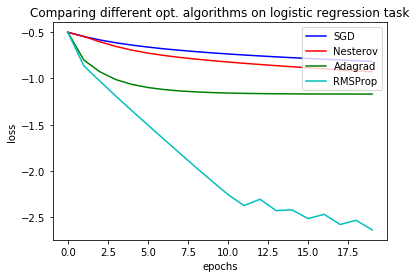

In [139]:
plt.title('Comparing different opt. algorithms on logistic regression task')
plt.plot(range(len(J_sgd)), J_sgd, c='b', label='SGD')
plt.legend(loc='upper right')
plt.plot(range(len(J_nes)), J_nes, c='r',  label='Nesterov')
plt.legend(loc='upper right')
plt.plot(range(len(J_ada)), J_ada, c='g',  label='Adagrad')
plt.legend(loc='upper right')
plt.plot(range(len(J_rms)), J_rms, c='c',  label='RMSProp')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()